In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import scienceplots

qml.drawer.use_style(style='sketch')

## Description of the Quantum Phase Estimation Algorithm

Let $U$ be a unitary operator with an eigenvector $|\psi\rangle$ and eigenvalue $e^{2\pi i \theta}$, where $\theta$ is the phase of the eigenvalue.
The goal of the Quantum Phase Estimation (QPE) algorithm is to estimate $\theta$.

1. Assume we have a unitary operator $U$ and its corresponding eigenvector $|\psi⟩$, satisfying $U|\psi⟩ = e^{2\pi i \theta}|\psi⟩$, where $\theta$ is the phase we want to estimate.

2. Prepare an input state consisting of an $n$-qubit register $|0⟩^{\otimes n}$ and $|\psi⟩$:
   
   $$ |\Psi_0⟩ = |0⟩^{\otimes n} \otimes |\psi⟩ $$

3. Apply Hadamard gates to the $n$-qubit register to create a uniform superposition state:
   
   $$ |\Psi_1⟩ = \left(\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} |k⟩\right) \otimes |\psi⟩ $$

4. Apply controlled-$U^{2^j}$ operations sequentially for $j = 0, 1, \ldots, n-1$:
   
   $$ |\Psi_2⟩ = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} |k⟩ \otimes U^{k_0 + 2k_1 + \cdots + 2^{n-1}k_{n-1}} |\psi⟩ = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} e^{2\pi i k \theta} |k⟩ \otimes |\psi⟩ $$
   
   where $k_i$ represents the $i$-th bit of the binary representation of $k$.

   i.e. for $n=2$, $|\psi\rangle|00\rangle+|\psi\rangle|01\rangle+|\psi\rangle|10\rangle+|\psi\rangle|11\rangle \rightarrow|\psi\rangle|00\rangle+U|\psi\rangle|01\rangle+U^2|\psi\rangle|10\rangle+U^3|\psi\rangle|11\rangle$ .

5. Apply the Inverse Quantum Fourier Transform (IQFT) to the $n$-qubit register:
   
   $$
   \begin{aligned}
   \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} e^{2\pi i k \theta} \text{IQFT}|k⟩ &= \frac{1}{2^n} \sum_{x=0}^{2^n-1} \sum_{k=0}^{2^n-1} e^{2\pi i k \theta} e^{-2\pi i k x / 2^n} |x⟩ \\
   &= \frac{1}{2^n} \sum_{x=0}^{2^n-1} \sum_{k=0}^{2^n-1} e^{-2\pi i k (x - 2^n \theta) / 2^n} |x⟩ \\
   \end{aligned}
   $$

   We can approximate $\theta \in [0,1]$ by rounding $2^n \theta$ to the nearest integer.
   $$ 2^n \theta = a + 2^n \delta $$
   where $a$ is the integer part of $2^n \theta$ and $\delta$ is the fractional part of $2^n \theta$.
   Then the above equation becomes

   $$
   \begin{aligned}
   |\Psi_3⟩ &= \sum_{x=0}^{2^n-1} \alpha_x |x⟩ \otimes |\psi⟩ \\
   \end{aligned}
   $$
   where
   $$
   \alpha_x = \frac{1}{2^n} \sum_{k=0}^{2^n-1} e^{2\pi i k \delta} e^{-2\pi i k (x - a) / 2^n}
   $$

6. Measure the $n$-qubit register. Let $y$ be the measurement result. The probability of measuring $y$ is
   $$
   P(y) = |\alpha_y|^2 = \left| \frac{1}{2^n} \sum_{k=0}^{2^n-1} e^{2\pi i k \delta} e^{-2\pi i k (y - a) / 2^n} \right|^2
   $$
   
   - If $\delta = 0$, then $P(y) = 1$ for $y = a$ and $P(y) = 0$ for $y \neq a$.
   
   - If $\delta \neq 0$, then $P(y=a)$ is a function of $\delta$.
     $$
     P(y=a)=\frac{1}{2^{2 n}}\left|\sum_{k=0}^{2^n-1} e^{2 \pi i \delta k}\right|^2=\frac{1}{2^{2 n}}\left|\frac{1-e^{2 \pi i 2^n \delta}}{1-e^{2 \pi i \delta}}\right|^2 = \frac{1}{2^{2 n}}\left|\frac{2 \sin \left(\pi 2^n \delta\right)}{2 \sin (\pi \delta)}\right|^2 \geq \frac{4}{\pi^2}
     $$ 

## Visualize probability

theta = 0.1750, y = 1.4000, a = 1.0000, delta = 0.0500


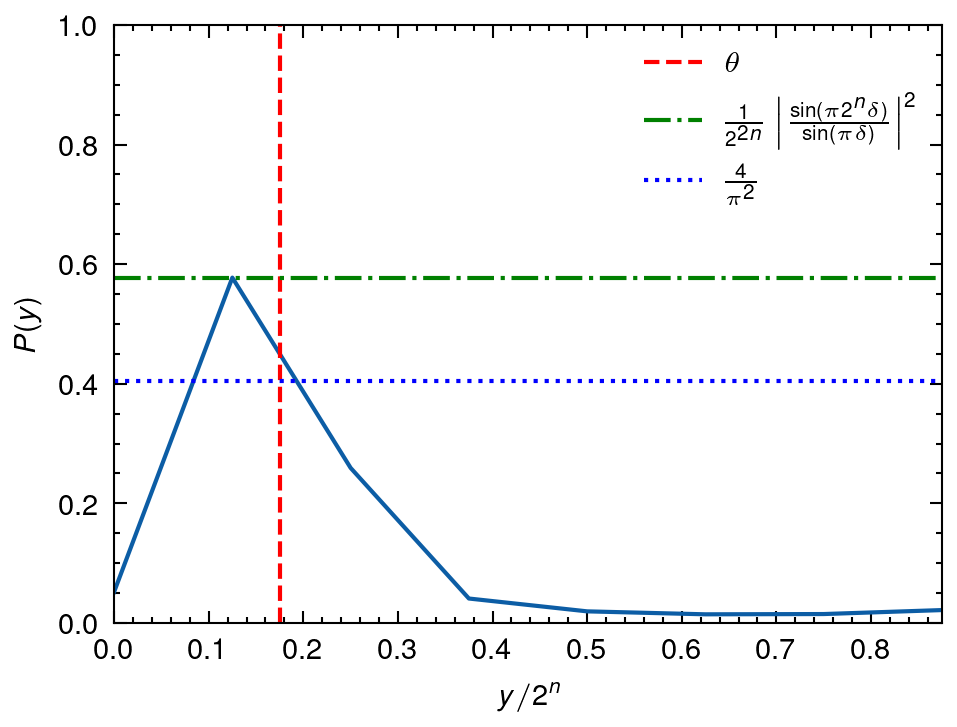

In [2]:
theta = 1.4/8
n = 3
y = 2**n * theta
a = round(y)
delta = (y - a) / 2**n

print(f"theta = {theta:.4f}, y = {y:.4f}, a = {a:.4f}, delta = {delta:.4f}")

def P(y):
    k = np.arange(0, 2**n)
    return np.absolute(1/2**n * np.sum(np.exp(2j*np.pi*k*delta) * np.exp(-2j*np.pi*k*(y-a) / 2**n))) ** 2

x = np.arange(0, 2**n)
P_vec = np.vectorize(P)(x)

with plt.style.context(['science', 'nature']):
    plt.figure(dpi=300)
    plt.plot(x / 2**n, P_vec)
    plt.axvline(theta, color='red', linestyle='--', label=r'$\theta$')
    plt.axhline(1/2**(2*n) * np.abs(np.sin(np.pi * 2**n * delta) / np.sin(np.pi * delta))**2, color='green', linestyle='-.', label=r'$\frac{1}{2^{2n}} \left| \frac{\sin(\pi 2^n \delta)}{\sin(\pi \delta)} \right|^2$')
    plt.axhline(4 / np.pi**2, color='blue', linestyle=':', label=r'$\frac{4}{\pi^2}$')
    plt.xlabel(r'$y / 2^n$')
    plt.ylabel(r'$P(y)$')
    plt.autoscale(tight=True)
    plt.tight_layout()
    plt.legend()
    plt.ylim((0, 1))
    
    plt.show()

## Quantum circuit for QPE

In [3]:
def convert_theta(theta):
    # to input PhaseShift gate
    return 2 * theta * np.pi

In [4]:
def gen_qpe_circuit(n:int):
    dev = qml.device("default.qubit", wires=n+1)
    @qml.qnode(dev)
    def circuit(theta:float):
        # For an eigenstate |psi> of U (PhaseShift gate)
        qml.PauliX(wires=n)

        # Apply Hadamard gate to the first n qubits
        for i in range(n):
            qml.Hadamard(wires=i)
        
        # Apply controlled unitary operations
        # for i in reversed(range(n)):
        #     qml.ControlledPhaseShift(convert_theta(theta) * 2**(n-1-i), wires=[i, n])
        qml.ControlledSequence(qml.PhaseShift(convert_theta(theta), wires=n), control=range(n))
        
        # Apply inverse QFT
        qml.adjoint(qml.QFT)(wires=range(n))

        return qml.probs(wires=range(n))

    return circuit
        

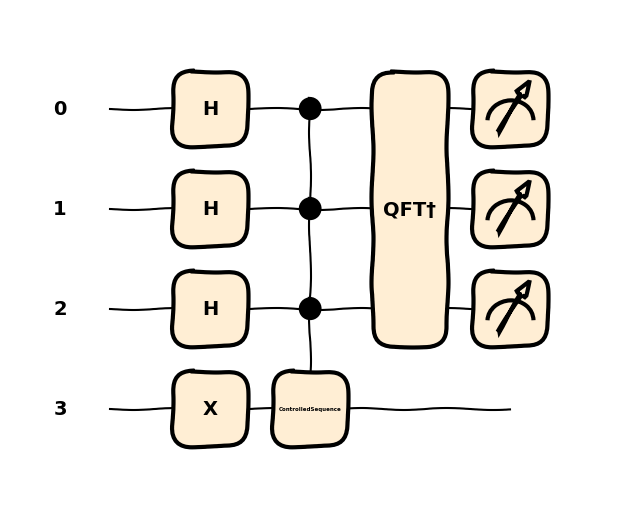

In [5]:
qpe_circuit = gen_qpe_circuit(n)
qml.draw_mpl(qpe_circuit)(theta)
plt.show()

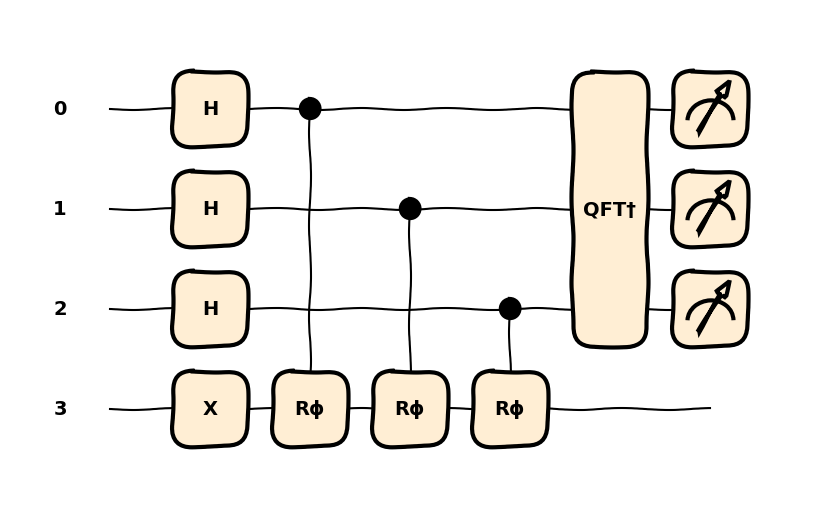

In [6]:
qml.draw_mpl(qpe_circuit, expansion_strategy="device")(theta)
plt.show()

In [7]:
qpe_circuit(theta)

tensor([0.05176813, 0.57752102, 0.25933562, 0.04090678, 0.01944022,
        0.01448748, 0.01494754, 0.02159322], requires_grad=True)

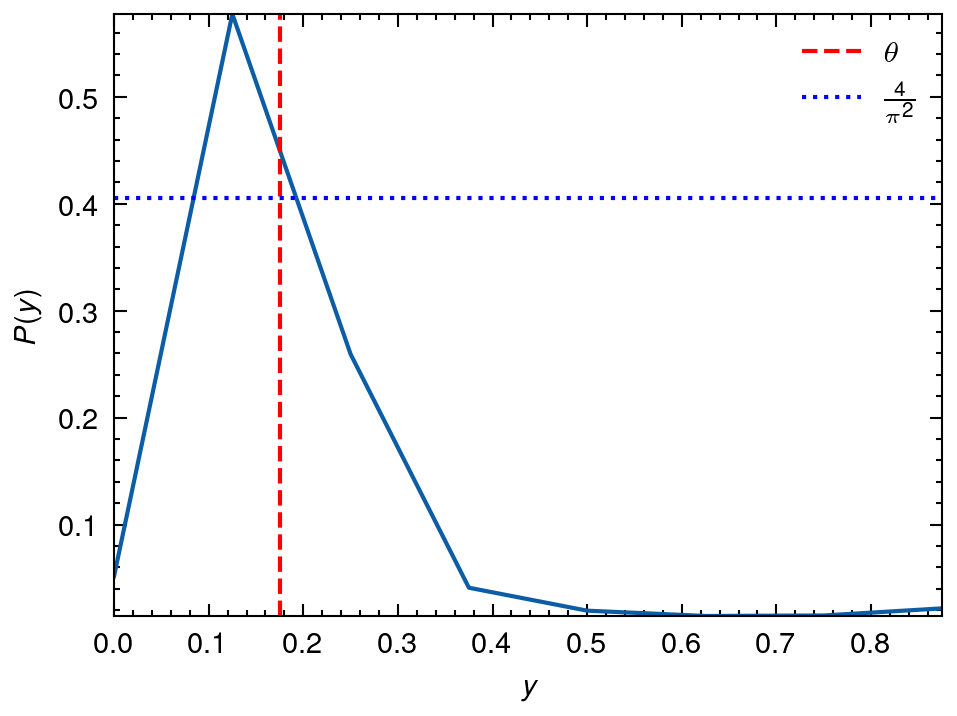

In [8]:
with plt.style.context(['science', 'nature']):
    plt.figure(dpi=300)
    plt.plot(np.arange(2**n) / 2**n, qpe_circuit(theta))
    plt.axvline(theta, color='red', linestyle='--', label=r'$\theta$')
    plt.axhline(4 / np.pi**2, color='blue', linestyle=':', label=r'$\frac{4}{\pi^2}$')
    plt.xlabel(r'$y$')
    plt.ylabel(r'$P(y)$')
    plt.autoscale(tight=True)
    plt.tight_layout()
    plt.legend()
    plt.show()

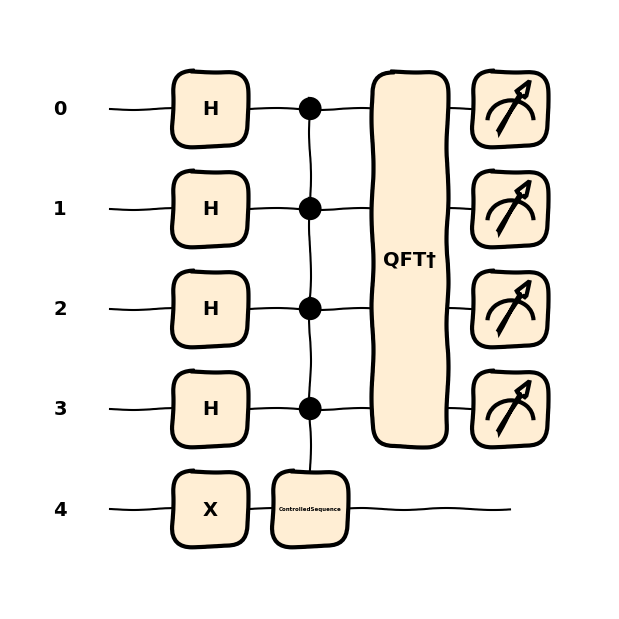

In [9]:
n=4
qpe_circuit = gen_qpe_circuit(n)
qml.draw_mpl(qpe_circuit)(theta)
plt.show()

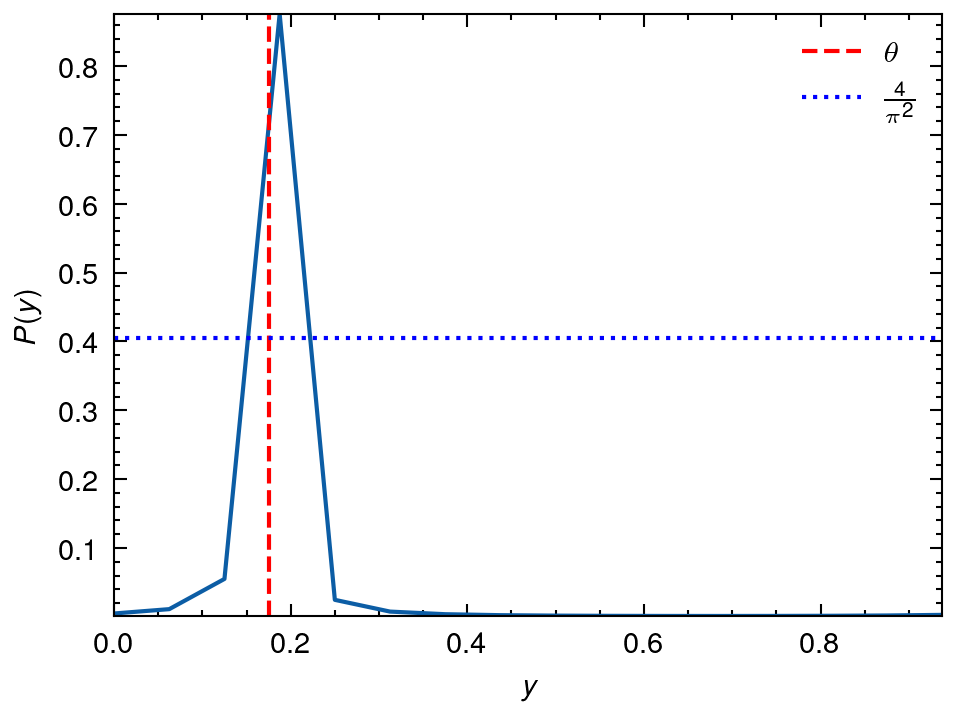

In [10]:
with plt.style.context(['science', 'nature']):
    plt.figure(dpi=300)
    plt.plot(np.arange(2**n) / 2**n, qpe_circuit(theta))
    plt.axvline(theta, color='red', linestyle='--', label=r'$\theta$')
    plt.axhline(4 / np.pi**2, color='blue', linestyle=':', label=r'$\frac{4}{\pi^2}$')
    plt.xlabel(r'$y$')
    plt.ylabel(r'$P(y)$')
    plt.autoscale(tight=True)
    plt.tight_layout()
    plt.legend()
    plt.show()